In [41]:
import prefect
from prefect import task, Flow, unmapped
import json
import boto3
import botocore

@task(name="GetBooksIt")
def get_books_itbooks():
    lambda_client = boto3.client('lambda')

    response = lambda_client.invoke(
        FunctionName='trial-docker-dev-get-books-itbooks',
        InvocationType='RequestResponse',
    )
    
    assert response["StatusCode"] < 300 # TODO change
    
    payload = json.loads(response['Payload'].read())
    print(payload)
    return payload

@task(name='GetBooksNYTimes')
def get_books_nytimes():
    lambda_client = boto3.client('lambda')

    response = lambda_client.invoke(
        FunctionName='trial-docker-dev-get-books-nytimes',
        InvocationType='RequestResponse'
    )
    
    assert response["StatusCode"] < 300

    payload = json.loads(response['Payload'].read())
    print(payload)
    return payload


@task(name="GetBooksBiblioteca")
def get_books_biblioteca():
    lambda_client = boto3.client('lambda')
    response = lambda_client.invoke(
        FunctionName='trial-docker-dev-get-books-biblioteca-nacional',
        InvocationType='RequestResponse'
    )
    
    assert response["StatusCode"] < 300

    payload = json.loads(response['Payload'].read())
    print(payload)
    return payload[0]


@task(name="CleanBooksBiblioteca")
def clean_books_biblioteca(csv_key):
    config = botocore.config.Config( # https://github.com/boto/boto3/issues/2424
        read_timeout=900,
        connect_timeout=900,
        retries={"max_attempts": 0}
    )
    lambda_client = boto3.client('lambda', config=config)
    response = lambda_client.invoke(
        FunctionName='trial-docker-dev-clean-books-biblioteca',
        InvocationType='RequestResponse',
        Payload = json.dumps({'csv_key':csv_key})
    )
    assert response["StatusCode"] < 300

    payload = json.loads(response['Payload'].read())
    print('Clean books!!!!!!')
    return payload


@task(name='InsertBooks')
def insert_books(books, source):
    config = botocore.config.Config( # https://github.com/boto/boto3/issues/2424
        read_timeout=900,
        connect_timeout=900,
        retries={"max_attempts": 0}
    )
    lambda_client = boto3.client('lambda', config=config)

    response = lambda_client.invoke(
        FunctionName='trial-docker-dev-insert-book',
        InvocationType='RequestResponse',
        Payload = json.dumps({'source':source, 'books': books})
        # Payload = f'{{"books":{json.dumps(books)}}}'
    )
    print('pepe')
    assert response["StatusCode"] < 300

@task(name='UpdateTable')
def update_stats_table():
    lambda_client = boto3.client('lambda')

    response = lambda_client.invoke(
        FunctionName='trial-docker-dev-update-table',
        InvocationType='RequestResponse',
    )
    
    assert response["StatusCode"] < 300

@task(name="InsertAux")
def insert_aux(books):
    print("LOCOOOOOOOO", books)

with Flow('ETL') as flow:
    it_books = get_books_itbooks()
    nytimes_books = get_books_nytimes()
    biblioteca_raw_books = get_books_biblioteca()
    biblioteca_clean_books = clean_books_biblioteca(biblioteca_raw_books, upstream_tasks=[biblioteca_raw_books])
    insert_biblioteca_books = insert_books(biblioteca_clean_books, source=unmapped('biblioteca'), upstream_tasks=[biblioteca_clean_books])
    
    
    
    
    # biblioteca_clean_books = clean_books_biblioteca.map(biblioteca_raw_books, upstream_tasks=[biblioteca_raw_books])
    # insert_aux = insert_aux.map(biblioteca_clean_books, upstream_tasks=[biblioteca_clean_books])
    # insert_biblioteca_books = insert_books.map(biblioteca_clean_books, source=unmapped('biblioteca'), upstream_tasks=[biblioteca_clean_books])
    
    
    
    
    # biblioteca_clean_books = clean_books_biblioteca(biblioteca_raw_books, upstream_tasks=[biblioteca_raw_books])
    # print(clean_books_biblioteca)
    # insert_it_books = insert_books.map(it_books, upstream_tasks=[it_books])
    # insert_nytimes_books = insert_books.map(nytimes_books, upstream_tasks=[nytimes_books])
    insert_it_books = insert_books(it_books,source='itbooks-api', upstream_tasks=[it_books])
    insert_nytimes_books = insert_books(nytimes_books, source='nytimes-api', upstream_tasks=[nytimes_books])
    update_stats_table(upstream_tasks=[insert_it_books, insert_nytimes_books, insert_biblioteca_books])


# @task
# def etl_bronze(bucket_name, prizes_path, laureates_path, aws_key, aws_secret, aws_token, aws_region):
#     lambda_client = boto3.client('lambda', aws_access_key_id=aws_key, aws_secret_access_key=aws_secret, aws_session_token=aws_token, region_name=aws_region)
#     response = lambda_client.invoke(
#         FunctionName='bronzeETL',
#         InvocationType='RequestResponse',
#         Payload = f'{{"bucketName": "{bucket_name}", "prizesPath": "{prizes_path}", "laureatePath": "{laureates_path}"}}'
#     )
#     assert response["StatusCode"] < 300

# @task
# def etl_silver(bronze_path, aws_key, aws_secret, aws_token, aws_region):    
#     lambda_client = boto3.client('lambda', aws_access_key_id=aws_key, aws_secret_access_key=aws_secret, aws_session_token=aws_token, region_name=aws_region)
#     response = lambda_client.invoke(
#         FunctionName='silverETL',
#         InvocationType='RequestResponse',
#         Payload = f'{{"bronzePath": "{bronze_path}"}}'
#     )
#     assert response["StatusCode"] < 300


# with Flow('ETL') as flow:
#     aws_key = Parameter("aws_access_key_id")
#     aws_secret = Parameter("aws_secret_access_key")
#     aws_token = Parameter("aws_session_token")
#     aws_region = Parameter("aws_region")
#     for category in ['che', 'eco', 'lit', 'pea', 'phy', 'med']:
#         laureates = extract_nobel_prizes(category, aws_key, aws_secret, aws_token, aws_region)
#         x1 = extract_laureate.map(laureates, unmapped(aws_key), unmapped(aws_secret), unmapped(aws_token), unmapped(aws_region), upstream_tasks=[laureates])
#     x2 = etl_bronze("capstone-13", "s3://capstone-13/raw/nobelPrizes/", "s3://capstone-13/raw/laureates/", aws_key, aws_secret, aws_token, aws_region, upstream_tasks=[x1])
#     etl_silver("s3://capstone-13/bronze/bronze_laureates.parquet", aws_key, aws_secret, aws_token, aws_region, upstream_tasks=[x2])


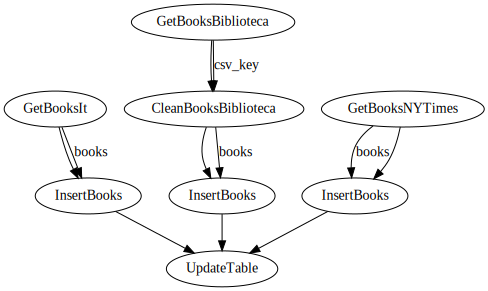

In [42]:
flow.visualize()

In [43]:
flow.run()

[2022-08-25 23:22:16+0200] INFO - prefect.FlowRunner | Beginning Flow run for 'ETL'
[2022-08-25 23:22:16+0200] INFO - prefect.TaskRunner | Task 'GetBooksIt': Starting task run...
[]
[2022-08-25 23:22:18+0200] INFO - prefect.TaskRunner | Task 'GetBooksIt': Finished task run for task with final state: 'Success'
[2022-08-25 23:22:18+0200] INFO - prefect.TaskRunner | Task 'InsertBooks': Starting task run...
pepe
[2022-08-25 23:22:18+0200] INFO - prefect.TaskRunner | Task 'InsertBooks': Finished task run for task with final state: 'Success'
[2022-08-25 23:22:18+0200] INFO - prefect.TaskRunner | Task 'GetBooksNYTimes': Starting task run...
[]
[2022-08-25 23:22:46+0200] INFO - prefect.TaskRunner | Task 'GetBooksNYTimes': Finished task run for task with final state: 'Success'
[2022-08-25 23:22:46+0200] INFO - prefect.TaskRunner | Task 'GetBooksBiblioteca': Starting task run...
['unzip/64d6262d2f4100df7446b552eef633bfc2e5e3649479b052e51ebcd9a9086c5f/MANUSCRITO_1-UTF8.csv', 'unzip/64d6262d2f4100

<Success: "All reference tasks succeeded.">